In [3]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [4]:
os.getcwd()

'/content'

In [5]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"


--2021-03-18 21:25:16--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.73.0.105, 2600:1409:12:285::e59, 2600:1409:12:2af::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.73.0.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   290MB/s    in 2.7s    

2021-03-18 21:25:19 (290 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]



In [6]:
local_zip = './cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [7]:
print(len(os.listdir('./PetImages/Cat/')))
print(len(os.listdir('./PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [8]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('./cats-v-dogs')
    os.mkdir('./cats-v-dogs/training')
    os.mkdir('./cats-v-dogs/testing')
    os.mkdir('./cats-v-dogs/training/dogs')
    os.mkdir('./cats-v-dogs/training/cats')
    os.mkdir('./cats-v-dogs/testing/dogs')
    os.mkdir('./cats-v-dogs/testing/cats')
except OSError:
    pass

In [9]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for file_name in os.listdir(SOURCE):
        path = os.path.join(SOURCE, file_name)
        if (os.path.getsize(path) > 0):
            files.append(file_name)
        else:
            print(file_name, " is zero length, so ignoring.")
    
    shuffled_files = random.sample(files, len(files))
    training_size = int(len(shuffled_files) * SPLIT_SIZE)
    testing_size = int(len(shuffled_files) - training_size)
    
    training_files = shuffled_files[:training_size]
    testing_files = shuffled_files[-testing_size:]
    
    for file_name in training_files:
        source = SOURCE + file_name
        destination = TRAINING + file_name
        copyfile(source, destination)
        
    for file_name in testing_files:
        source = SOURCE + file_name
        destination = TESTING + file_name
        copyfile(source, destination)


CAT_SOURCE_DIR = "./PetImages/Cat/"
TRAINING_CATS_DIR = "./cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "./cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "./PetImages/Dog/"
TRAINING_DOGS_DIR = "./cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "./cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg  is zero length, so ignoring.
11702.jpg  is zero length, so ignoring.


In [10]:
print(len(os.listdir('./cats-v-dogs/training/cats/')))
print(len(os.listdir('./cats-v-dogs/training/dogs/')))
print(len(os.listdir('./cats-v-dogs/testing/cats/')))
print(len(os.listdir('./cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [11]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
TRAINING_DIR = "./cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=128,
                                                   target_size=(150, 150),
                                                   class_mode='binary')

VALIDATION_DIR = "./cats-v-dogs/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             batch_size=128,
                                                             target_size=(150, 150),
                                                             class_mode='binary')



# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [13]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
176/176 [==============================] - ETA: 0s - loss: 2.0304 - accuracy: 0.5413

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

176/176 [==============================] - 106s 412ms/step - loss: 2.0246 - accuracy: 0.5415 - val_loss: 0.6896 - val_accuracy: 0.6356
Epoch 2/15
176/176 [==============================] - 71s 403ms/step - loss: 0.6976 - accuracy: 0.6589 - val_loss: 0.5290 - val_accuracy: 0.7304
Epoch 3/15
176/176 [==============================] - 72s 406ms/step - loss: 0.5190 - accuracy: 0.7436 - val_loss: 0.4978 - val_accuracy: 0.7624
Epoch 4/15
176/176 [==============================] - 71s 406ms/step - loss: 0.4694 - accuracy: 0.7857 - val_loss: 0.5443 - val_accuracy: 0.7864
Epoch 5/15
176/176 [==============================] - 72s 408ms/step - loss: 0.3649 - accuracy: 0.8394 - val_loss: 0.5296 - val_accuracy: 0.7616
Epoch 6/15
176/176 [==============================] - 71s 404ms/step - loss: 0.2404 - accuracy: 0.9024 - val_loss: 0.5350 - val_accuracy: 0.7472
Epoch 7/15
176/176 [==============================] - 71s 400ms/step - loss: 0.1509 - accuracy: 0.9432 - val_loss: 0.7551 - val_accuracy: 0.

Text(0.5, 1.0, 'Training and validation loss')

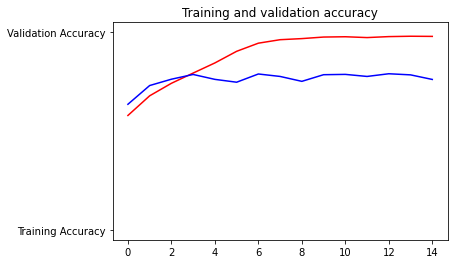

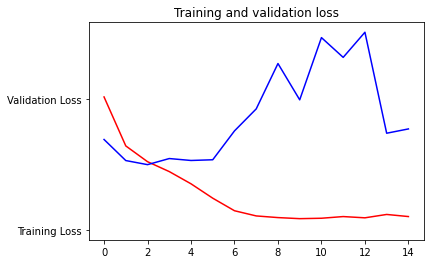

In [14]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)